# Tanzania Water Wells

## Business Problem

- Stakeholder: Tanzanian Ministry of Water 

- True business problem: Predict the functionality of wells by reducing false negatives and false positives, the main focus being on false negatives. 

- Deliverables: Inference or Prediction?
    - Prediction
- Context: 
    - False negative: Well functionality prediction says it is actully functional when it is not functional.
        
    - False positive: Well functionality prediction says it is not functional when it is functional.
        
    - We would prefer reducing **false positives** over false negatives

## Evalutation Metric

- Which metric would make sense to primarily use as we evaluate our models?
    - Accuracy - balances the two kinds of errors (but is impractical with imbalanced targets)
    - **Precision** - helps reduce false positives
    - **Recall** - helps reduce false negatives
    - F1-Score - balances recall & precision (and is beter than accuracy with imbalaced targets)
    - ROC-AUC - helps focus on better probability outputs (makes sure our predicted probabilities are better)
    
We will primarily be focusing on recall 

## Data Understanding 

### Terminology

- Functional
- Not functional
- Needs repair

## Imports

In [1]:
from datetime import date
from time import strftime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import LabelEncoder,  MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, recall_score,accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

##  Reading Data

In [2]:
features = pd.read_csv('../data/tanzania_features.csv')
features

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [3]:
target=pd.read_csv('../data/tanzania_target.csv')
target

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [4]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [5]:
features.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [6]:
new_df = features.merge(target, on='id')

In [7]:
clean_df=new_df.drop(columns=['id', 'waterpoint_type', 'scheme_name', 'funder',
        'num_private', 'permit', 'extraction_type', 'extraction_type_group',
        'region_code','lga','ward', 'recorded_by', 'public_meeting',
        'scheme_management', 'payment','water_quality', 'source_class','subvillage','quantity_group'
                             ,'management', 'source_type'])

In [8]:
# Dropping zeros
clean_df = clean_df[clean_df['construction_year']!=0]

In [9]:
# Dropping zeros
clean_df = clean_df[clean_df['longitude']!=0]

In [10]:
# Dropping zeros
clean_df = clean_df[clean_df['latitude']!=-2.000000e-08]

# Models

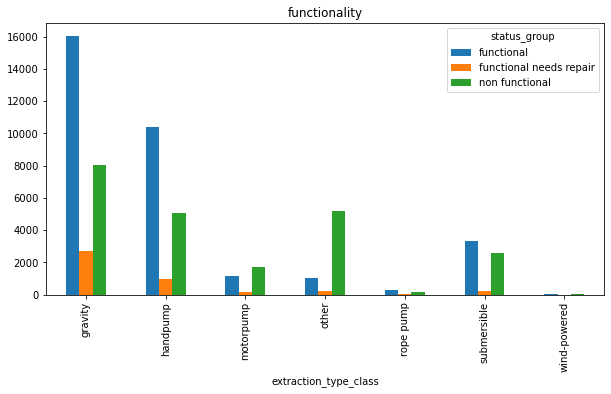

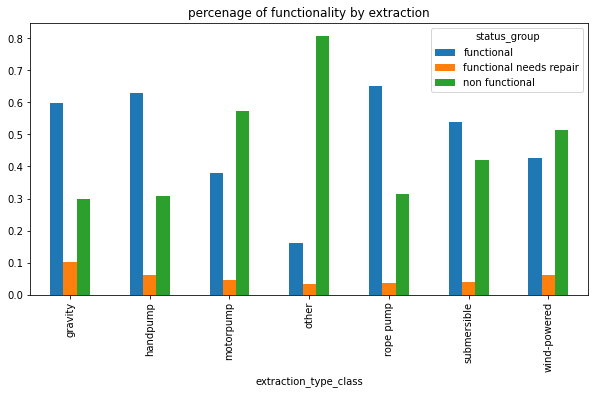

In [11]:
mplines = new_df.groupby('extraction_type_class')['status_group'].value_counts(normalize=False).unstack().plot(kind='bar', figsize=(10,5))
mplines.set_title("functionality")
plt.show()
mplines_pct = new_df.groupby('extraction_type_class')['status_group'].value_counts(normalize=True).unstack().plot(kind='bar', figsize=(10,5))
mplines_pct.set_title("percenage of functionality by extraction")
plt.show()

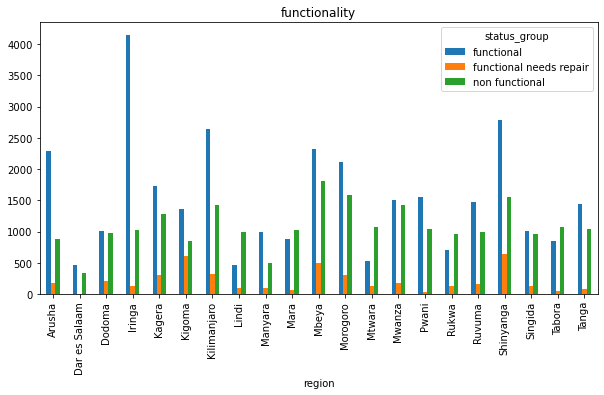

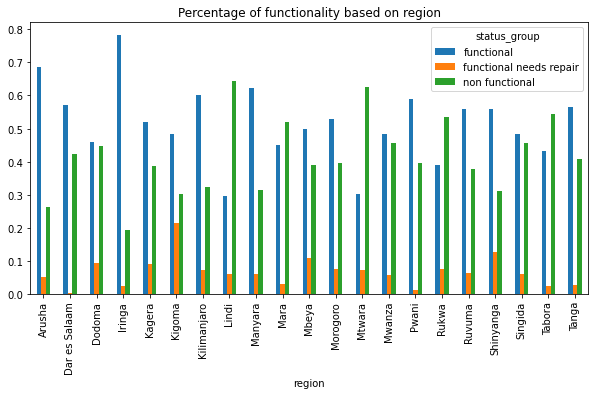

In [12]:
#functionality in region 
mplines = new_df.groupby('region')['status_group'].value_counts(normalize=False).unstack().plot(kind='bar', figsize=(10,5))
mplines.set_title("functionality")
plt.show()
mplines_pct = new_df.groupby('region')['status_group'].value_counts(normalize=True).unstack().plot(kind='bar', figsize=(10,5))
mplines_pct.set_title("Percentage of functionality based on region")
plt.show()

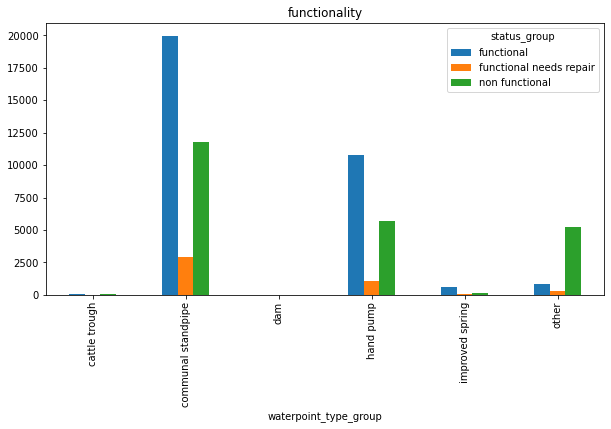

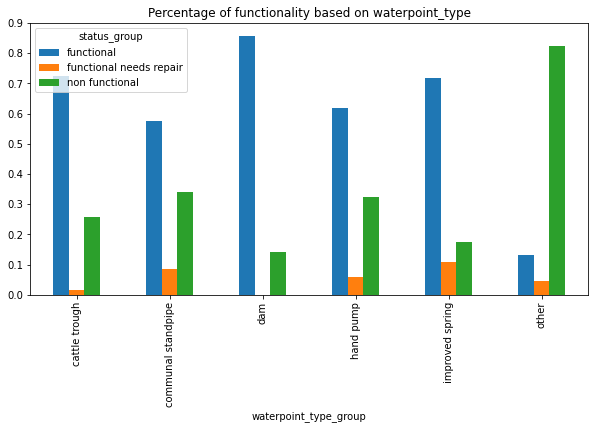

In [13]:
#waterpoint_type_group functionality 
mplines = new_df.groupby('waterpoint_type_group')['status_group'].value_counts(normalize=False).unstack().plot(kind='bar', figsize=(10,5))
mplines.set_title("functionality")
plt.show()
mplines_pct = new_df.groupby('waterpoint_type_group')['status_group'].value_counts(normalize=True).unstack().plot(kind='bar', figsize=(10,5))
mplines_pct.set_title("Percentage of functionality based on waterpoint_type")
plt.show()

In [14]:
#combining non-functional and needs repair 
clean_df['status_group'] = clean_df["status_group"].replace("functional needs repair", "non functional")

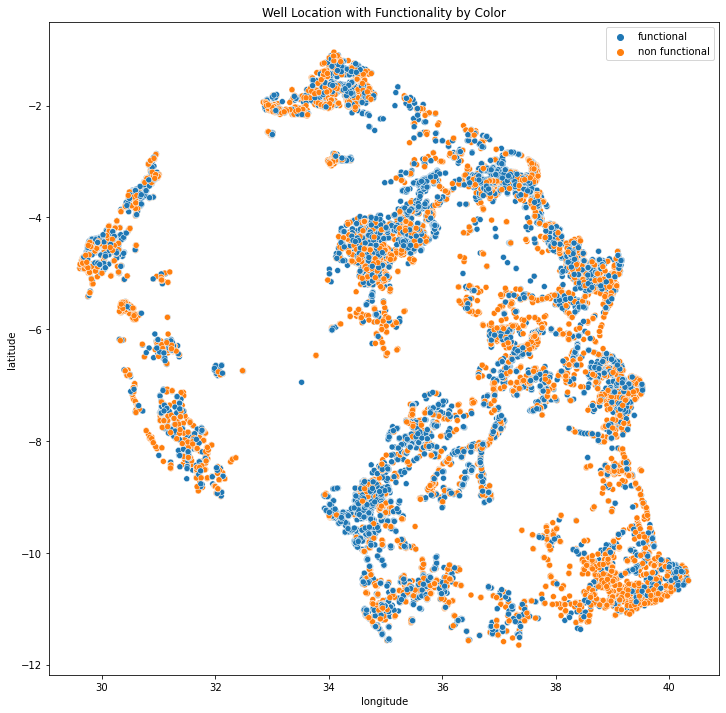

In [15]:
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(x='longitude', y='latitude', hue='status_group', data=clean_df, ax=ax)
plt.title('Well Location with Functionality by Color')
plt.legend(fancybox=True);

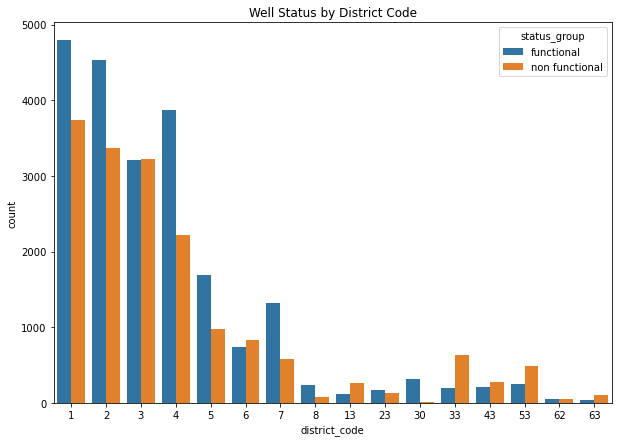

In [16]:
plt.figure(figsize=(10, 7))

sns.countplot(data=clean_df,x='district_code',hue='status_group')
plt.title('Well Status by District Code');

In [17]:
#combining non-functional and needs repair 
clean_df['status_group'] = clean_df["status_group"].replace("functional needs repair", "non functional")

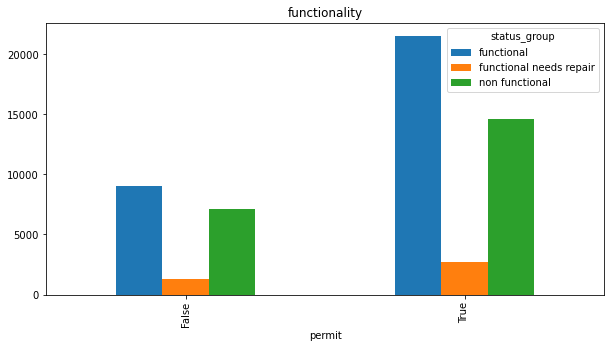

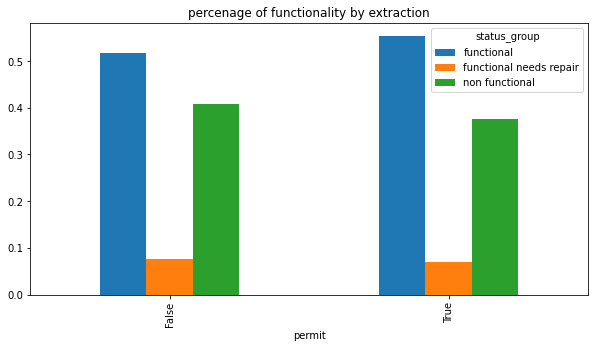

In [18]:
# permit vs non-permit 
mplines = new_df.groupby('permit')['status_group'].value_counts(normalize=False).unstack().plot(kind='bar', figsize=(10,5))
mplines.set_title("functionality")
plt.show()
mplines_pct = new_df.groupby('permit')['status_group'].value_counts(normalize=True).unstack().plot(kind='bar', figsize=(10,5))
mplines_pct.set_title("percenage of functionality by extraction")
plt.show()

In [19]:
cat_df=clean_df[['status_group','region','extraction_type_class',
                 'construction_year','source','quantity','longitude','latitude']]

In [20]:
model_df = pd.get_dummies(cat_df)
model_df

,construction_year,longitude,latitude,status_group_functional,status_group_non functional,region_Arusha,region_Dar es Salaam,region_Iringa,region_Kigoma,region_Kilimanjaro,...,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown
0,1999,34.938093,-9.856322,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2010,34.698766,-2.147466,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,2009,37.460664,-3.821329,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1986,38.486161,-11.155298,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,2009,39.172796,-4.765587,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59391,1967,38.044070,-4.272218,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
59394,2007,37.634053,-6.124830,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
59395,1999,37.169807,-3.253847,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
59396,1996,35.249991,-9.070629,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


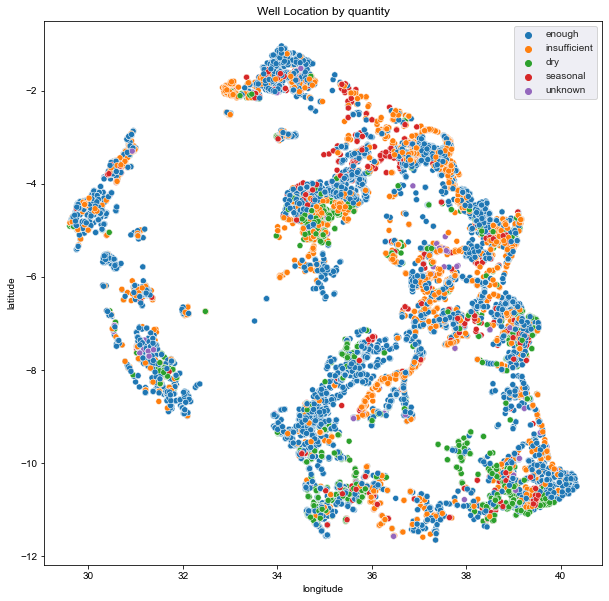

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue="quantity", data=clean_df, ax=ax)
plt.title('Well Location by quantity')

plt.legend(fancybox=True);

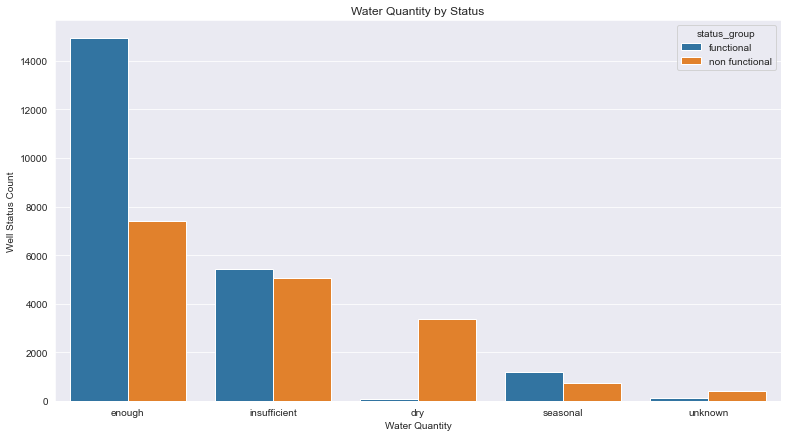

In [22]:
plt.figure(figsize=(13, 7))

sns.countplot(data=clean_df,x='quantity',hue='status_group')
plt.title('Water Quantity by Status')
plt.xlabel('Water Quantity')
plt.ylabel('Well Status Count');

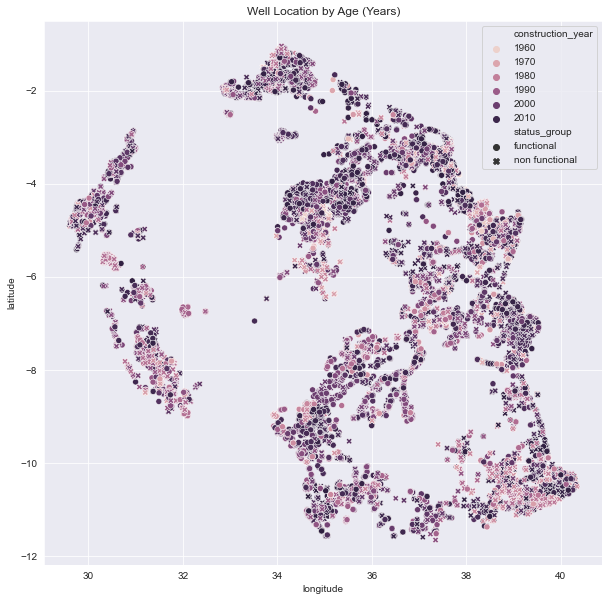

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue="construction_year", style='status_group', data=clean_df, ax=ax)
plt.title('Well Location by Age (Years)')

plt.legend(fancybox=True);

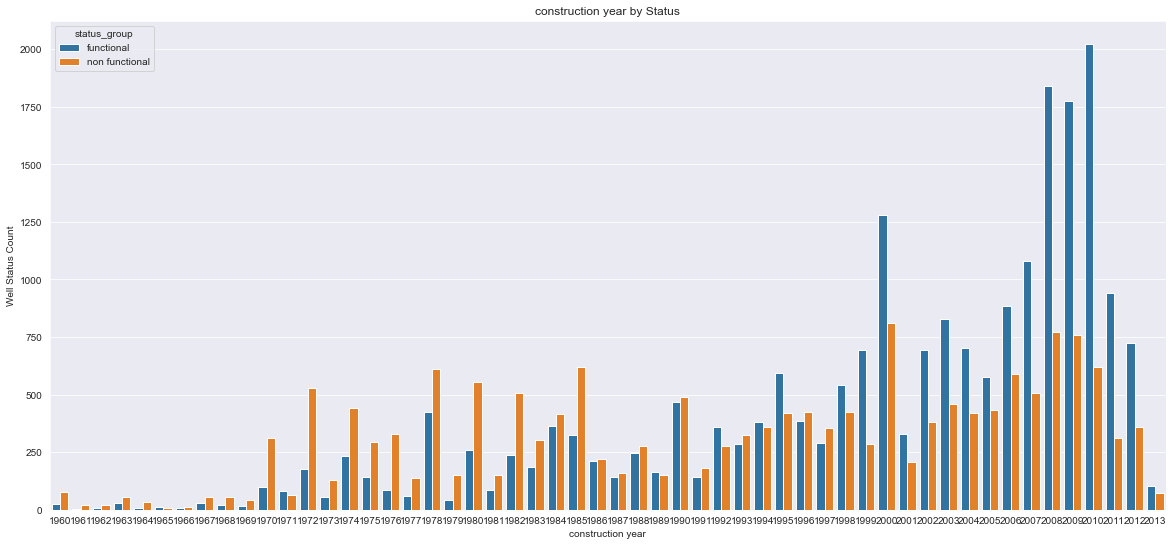

In [80]:
#from 1997 back (1960) there is only one year where there were more functional 
# wells built than not 
plt.figure(figsize=(20, 9))

sns.countplot(data=clean_df,x='construction_year',hue='status_group')
plt.title('construction year by Status')
plt.xlabel('construction year')
plt.ylabel('Well Status Count');
plt.savefig('Images/', bbox_inches = 'tight')

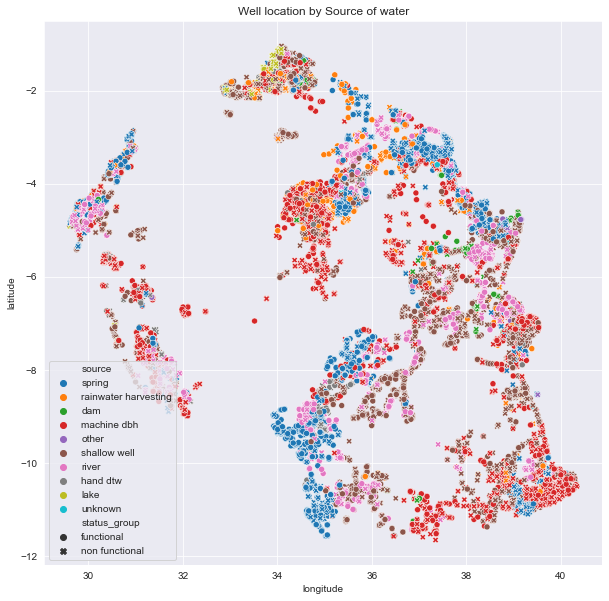

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue="source", style='status_group', data=clean_df, ax=ax)
plt.title('Well location by Source of water')

plt.legend(fancybox=True);

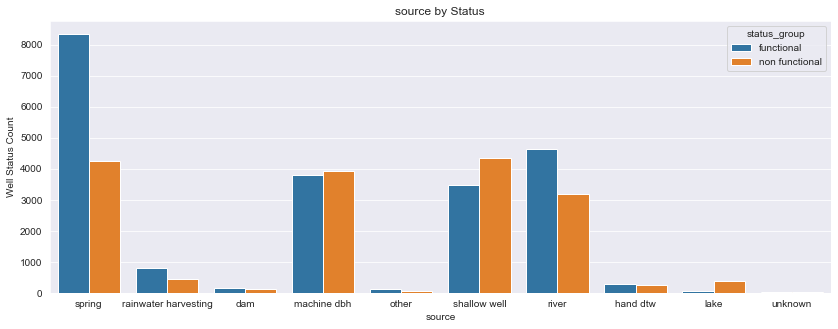

In [26]:
#machine dbh/shallow well/lake all have more non-functioning wells than functioning
#spring water and lakes provide the majority of functioning wells 
plt.figure(figsize=(14,5))

sns.countplot(data=clean_df,x='source',hue='status_group')
plt.title('source by Status')
plt.xlabel('source')
plt.ylabel('Well Status Count');

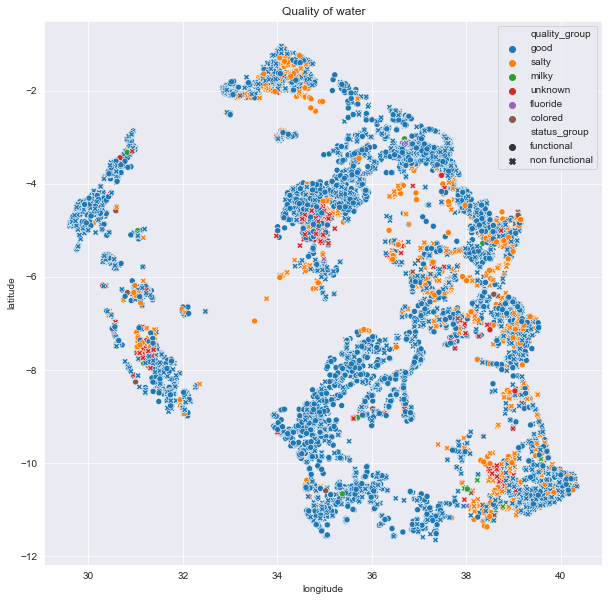

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue="quality_group", style='status_group', data=clean_df, ax=ax)
plt.title('Quality of water')

plt.legend(fancybox=True);


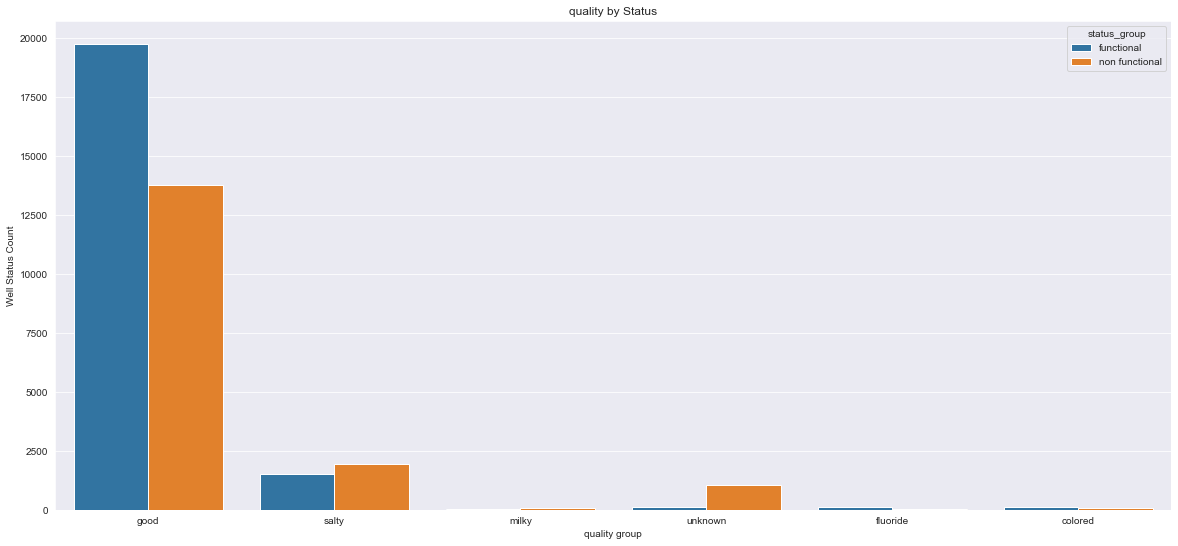

In [28]:
#both salty and unkown often produce non-functioning wells 
#good still has a fair amount of non-functioning wells. But when compared to its amount of functioning ones 
#,we can assume it produces better outcomes for a wells overall status. 
#roughly 32,000 'good' quality wells.
plt.figure(figsize=(20, 9))

sns.countplot(data=clean_df,x='quality_group',hue='status_group')
plt.title('quality by Status')
plt.xlabel('quality group')
plt.ylabel('Well Status Count');

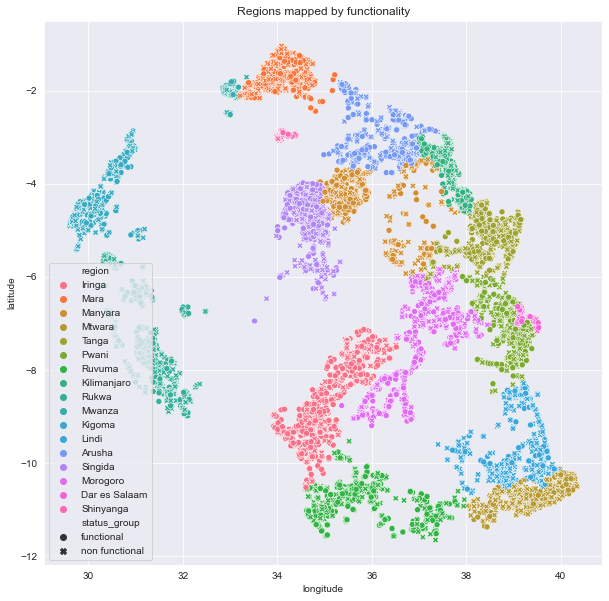

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue="region", style='status_group', data=clean_df, ax=ax)
plt.title('Regions mapped by functionality')

plt.legend(fancybox=True);

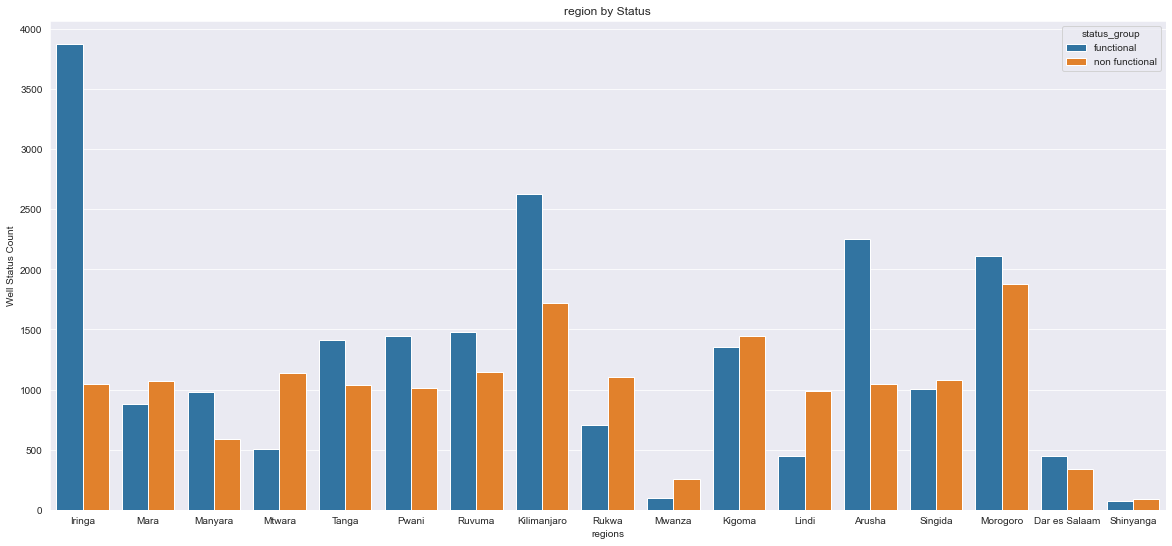

In [30]:
plt.figure(figsize=(20, 9))

sns.countplot(data=clean_df,x='region',hue='status_group')
plt.title('region by Status')
plt.xlabel('regions')
plt.ylabel('Well Status Count');

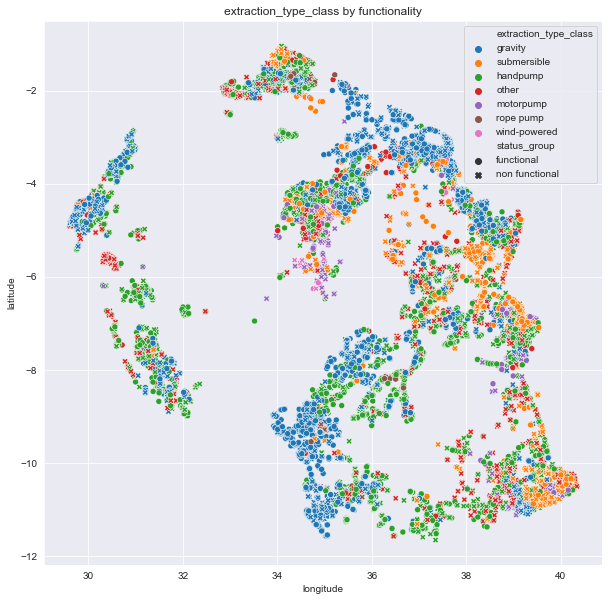

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue="extraction_type_class", style='status_group', data=clean_df, ax=ax)
plt.title('extraction_type_class by functionality')

plt.legend(fancybox=True);

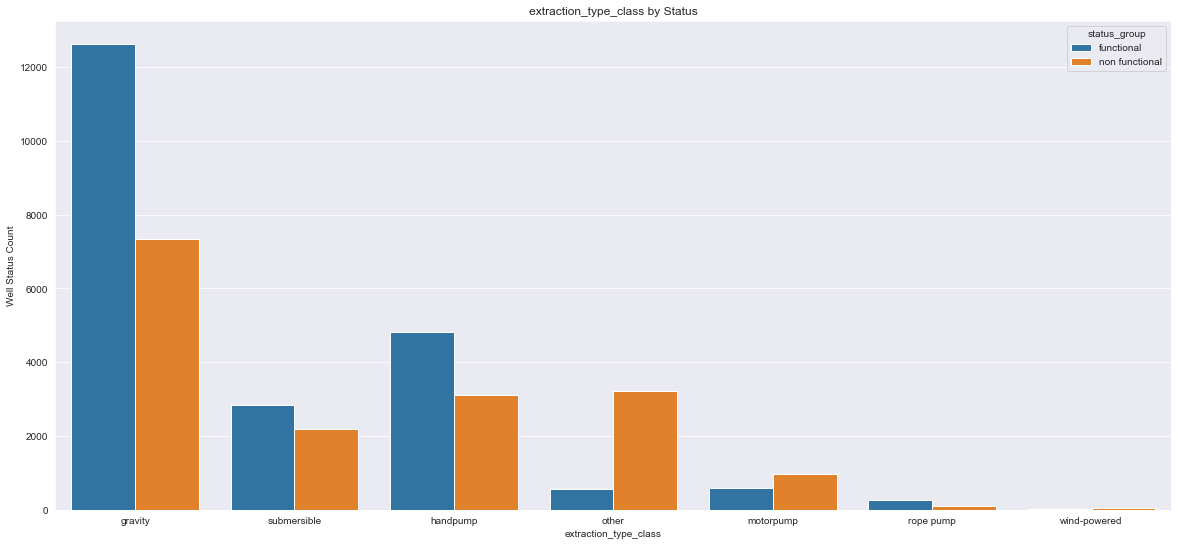

In [32]:
#other and handpump techniques produce non-functioning wells 
plt.figure(figsize=(20, 9))

sns.countplot(data=clean_df,x='extraction_type_class',hue='status_group')
plt.title('extraction_type_class by Status')
plt.xlabel('extraction_type_class')
plt.ylabel('Well Status Count');

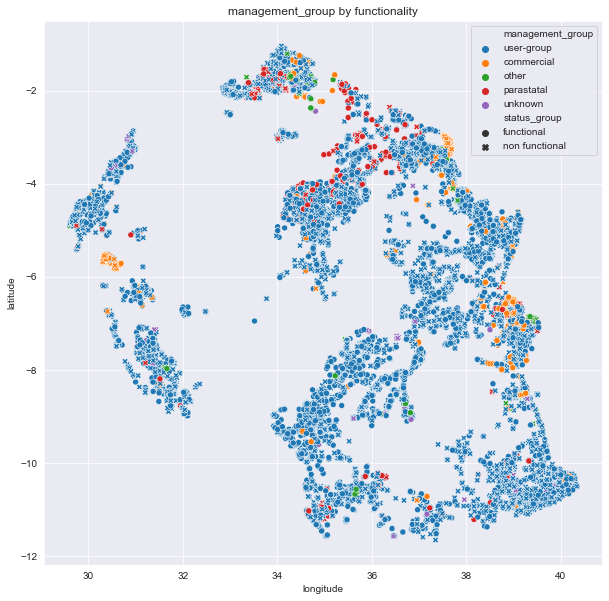

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue="management_group", style='status_group', data=clean_df, ax=ax)
plt.title('management_group by functionality')

plt.legend(fancybox=True);

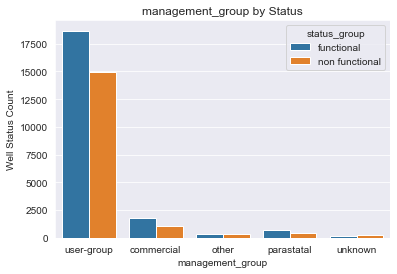

In [34]:
sns.countplot(data=clean_df,x='management_group',hue='status_group')
plt.title('management_group by Status')
plt.xlabel('management_group')
plt.ylabel('Well Status Count');

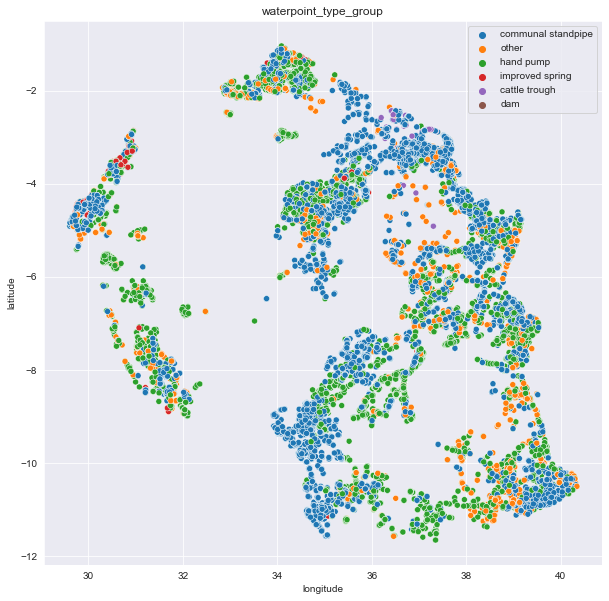

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue="waterpoint_type_group", data=clean_df, ax=ax)
plt.title('waterpoint_type_group')

plt.legend(fancybox=True);


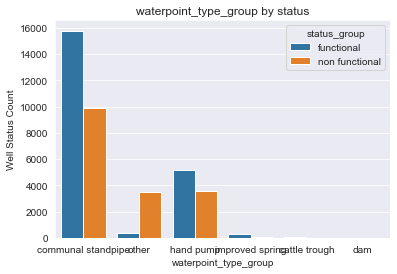

In [36]:
sns.countplot(data=clean_df,x='waterpoint_type_group',hue='status_group')
plt.title('waterpoint_type_group by status')
plt.xlabel('waterpoint_type_group')
plt.ylabel('Well Status Count');

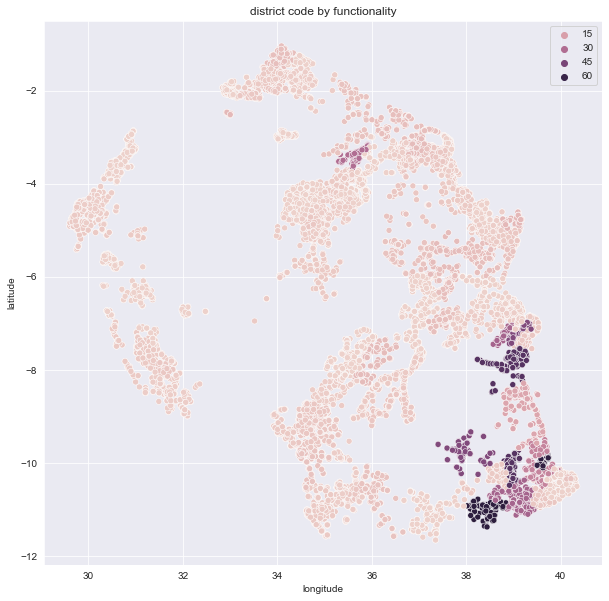

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style('darkgrid')
sns.scatterplot(x='longitude', y='latitude', hue='district_code', data=clean_df, ax=ax)
plt.title('district code by functionality')

plt.legend(fancybox=True);


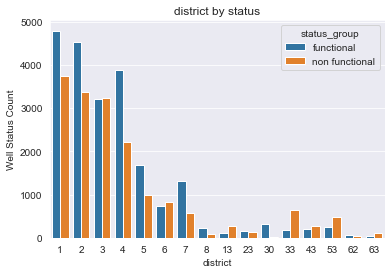

In [38]:
sns.countplot(data=clean_df,x='district_code',hue='status_group')
plt.title('district by status')
plt.xlabel('district')
plt.ylabel('Well Status Count');

## Further Analysis model prep

In [39]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38691 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             38691 non-null  float64
 1   date_recorded          38691 non-null  object 
 2   gps_height             38691 non-null  int64  
 3   installer              37345 non-null  object 
 4   longitude              38691 non-null  float64
 5   latitude               38691 non-null  float64
 6   wpt_name               38691 non-null  object 
 7   basin                  38691 non-null  object 
 8   region                 38691 non-null  object 
 9   district_code          38691 non-null  int64  
 10  population             38691 non-null  int64  
 11  construction_year      38691 non-null  int64  
 12  extraction_type_class  38691 non-null  object 
 13  management_group       38691 non-null  object 
 14  payment_type           38691 non-null  object 
 15  qu

In [40]:
cat_df=clean_df[['status_group','region','extraction_type_class',
                 'construction_year','source','quantity','longitude','latitude']]

In [41]:
model_df = pd.get_dummies(cat_df)
model_df

,construction_year,longitude,latitude,status_group_functional,status_group_non functional,region_Arusha,region_Dar es Salaam,region_Iringa,region_Kigoma,region_Kilimanjaro,...,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown
0,1999,34.938093,-9.856322,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2010,34.698766,-2.147466,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,2009,37.460664,-3.821329,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1986,38.486161,-11.155298,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,2009,39.172796,-4.765587,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59391,1967,38.044070,-4.272218,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
59394,2007,37.634053,-6.124830,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
59395,1999,37.169807,-3.253847,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
59396,1996,35.249991,-9.070629,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


In [42]:
model_df.columns

Index(['construction_year', 'longitude', 'latitude', 'status_group_functional',
       'status_group_non functional', 'region_Arusha', 'region_Dar es Salaam',
       'region_Iringa', 'region_Kigoma', 'region_Kilimanjaro', 'region_Lindi',
       'region_Manyara', 'region_Mara', 'region_Morogoro', 'region_Mtwara',
       'region_Mwanza', 'region_Pwani', 'region_Rukwa', 'region_Ruvuma',
       'region_Shinyanga', 'region_Singida', 'region_Tanga',
       'extraction_type_class_gravity', 'extraction_type_class_handpump',
       'extraction_type_class_motorpump', 'extraction_type_class_other',
       'extraction_type_class_rope pump', 'extraction_type_class_submersible',
       'extraction_type_class_wind-powered', 'source_dam', 'source_hand dtw',
       'source_lake', 'source_machine dbh', 'source_other',
       'source_rainwater harvesting', 'source_river', 'source_shallow well',
       'source_spring', 'source_unknown', 'quantity_dry', 'quantity_enough',
       'quantity_insufficient', 'q

In [43]:
model_df

,construction_year,longitude,latitude,status_group_functional,status_group_non functional,region_Arusha,region_Dar es Salaam,region_Iringa,region_Kigoma,region_Kilimanjaro,...,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown
0,1999,34.938093,-9.856322,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2010,34.698766,-2.147466,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,2009,37.460664,-3.821329,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1986,38.486161,-11.155298,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,2009,39.172796,-4.765587,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59391,1967,38.044070,-4.272218,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
59394,2007,37.634053,-6.124830,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
59395,1999,37.169807,-3.253847,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
59396,1996,35.249991,-9.070629,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


## Train test split

In [44]:
y= model_df['status_group_non functional']
X= model_df.drop(columns=['status_group_non functional', 'status_group_functional'])

In [45]:
y.value_counts(normalize=True)

0    0.560957
1    0.439043
Name: status_group_non functional, dtype: float64

In [46]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.15, random_state=2022, stratify=y)


In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.15, random_state=2022, stratify=y_tr)


## Model 1 - Logreg1

In [48]:
def modeling_function(model, X_train, y_train, X_val, y_val):

    # fit model on training data
    model.fit(X_train, y_train)

    # make predictions on training and validation data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Print accuracy score
    print('Training accuracy: ', accuracy_score(y_train, train_preds))
    print('Validation accuracy: ', accuracy_score(y_val, val_preds))

    # return fitted model
    return model

In [49]:
logreg = LogisticRegression()

In [50]:
logreg = modeling_function(logreg, X_train, y_train, X_val, y_val)


Training accuracy:  0.7059349622580761
Validation accuracy:  0.7117957032833401


/Users/litzysalazar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
perm_log=permutation_importance(logreg,X_test,y_test, n_repeats=10, random_state=2022)
perm_log

{'importances_mean': array([-6.89179876e-05,  1.44727774e-03,  1.32667126e-03,  4.39352171e-03,
         8.61474845e-05,  4.99655410e-04,  3.01516196e-03,  3.44589938e-05,
         8.44245348e-04,  7.58097864e-04,  5.84079945e-03,  1.89524466e-04,
         1.17160579e-03,  1.72294969e-04,  1.72294969e-05,  8.95933839e-04,
         1.89524466e-03, -3.44589938e-05,  2.70503101e-03,  1.55065472e-04,
         6.71950379e-04,  2.92729152e-02,  2.51550655e-03,  1.85217092e-02,
         9.82081323e-04,  4.56581668e-03,  0.00000000e+00,  0.00000000e+00,
         3.44589938e-05,  6.78842178e-03,  1.60234321e-03,  3.44589938e-05,
         1.11991730e-03,  7.06409373e-04, -1.10268780e-03, -1.25775327e-03,
         0.00000000e+00,  4.18504480e-02,  5.28084080e-02,  1.69365955e-02,
         5.92694693e-03, -7.40868367e-04]),
 'importances_std': array([8.44069519e-05, 1.34169003e-03, 7.06409373e-04, 9.47622329e-04,
        1.92631631e-04, 1.73402711e-03, 1.49261549e-03, 9.58678687e-04,
        1.049

In [52]:
y_scores = cross_val_predict(logreg, X_train, y_train, cv=3,
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

/Users/litzysalazar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/litzysalazar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

# Logreg 2

In [53]:
logreg2 = LogisticRegression(penalty='l1', solver='liblinear')

In [54]:
logreg2.fit(X_train, y_train)


/Users/litzysalazar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(penalty='l1', solver='liblinear')

In [55]:
logreg2 = modeling_function(logreg2, X_train, y_train, X_val, y_val)


Training accuracy:  0.7309412227667871
Validation accuracy:  0.7381434941224159


/Users/litzysalazar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [56]:
logreg2_coefs = pd.DataFrame(np.abs(logreg2.coef_.T), columns=['coefficient'], index=X_train.columns)


In [57]:
sorted2_coefs = logreg2_coefs.sort_values(by='coefficient', ascending=False)


## Random Forest

In [58]:
forest = RandomForestClassifier(max_depth=2, random_state=101)
forest.fit(X_train, y_train)


y_forest_pred = forest.predict(X_test)

print('Accuracy of random forest classifier: {:.2f}'.format(forest.score(X_test, y_test)))

Accuracy of random forest classifier: 0.70


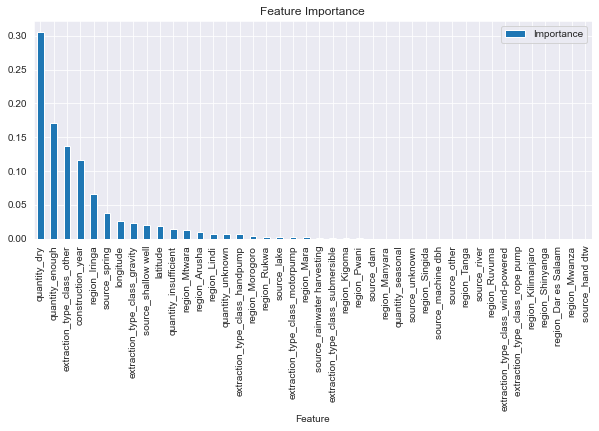

In [59]:
importances = pd.DataFrame({'Feature': X_train.columns,
                            'Importance': forest.feature_importances_}).set_index('Feature').sort_values('Importance',ascending=False)

# plot the importances
importances = importances.plot(kind='bar', figsize=(10,4))
importances = importances.set_title("Feature Importance")
plt.show()

## Grid Search on Random Forest

In [60]:
param_grid1 = {'n_estimators': [50, 75, 100],
                'max_depth': [1, 3, 5, 7, 10],
                'min_samples_leaf': [1, 3, 5, 7]}

In [61]:
rf_gs = GridSearchCV(estimator=forest, param_grid=param_grid1, scoring='accuracy')


In [62]:
rf_gs.fit(X_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(max_depth=2, random_state=101),
             param_grid={'max_depth': [1, 3, 5, 7, 10],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [50, 75, 100]},
             scoring='accuracy')

In [63]:
forest_model = rf_gs.best_estimator_


In [64]:
modeling_function(forest_model, X_train, y_train, X_val, y_val)


Training accuracy:  0.7936536328837692
Validation accuracy:  0.7813133360356709


RandomForestClassifier(max_depth=10, n_estimators=50, random_state=101)

## Decision Tree

In [65]:
dt = DecisionTreeClassifier(random_state = 2022)


In [66]:
dt = modeling_function(dt, X_train, y_train, X_val, y_val)


Training accuracy:  1.0
Validation accuracy:  0.7805026347790839


## Decision Tree Grid Search

In [67]:

param_grid2 = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}

dtree_gscv = GridSearchCV(dt, param_grid2, cv=3)
    
dtree_gscv.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=2022),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [68]:
dtree_gscv.best_estimator_

DecisionTreeClassifier(max_depth=14, random_state=2022)

In [69]:
modeling_function(dtree_gscv, X_train, y_train, X_val, y_val)

Training accuracy:  0.832146817872858
Validation accuracy:  0.7800972841507904


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=2022),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

## Decision Tree Recall

In [70]:
final_model = dtree_gscv

In [71]:
y_pred = final_model.predict(X_test)


In [72]:
print('-'*40)
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

print('-'*40)
print('Recall Score:')
print(recall_score(y_test, y_pred))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_pred))

----------------------------------------
Accuracy Score:
0.7851481736733288
----------------------------------------
Recall Score:
0.7048665620094191
----------------------------------------
Confusion Matrix:
[[2761  495]
 [ 752 1796]]
----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      3256
           1       0.78      0.70      0.74      2548

    accuracy                           0.79      5804
   macro avg       0.78      0.78      0.78      5804
weighted avg       0.79      0.79      0.78      5804



## XG Boost

In [74]:
y_test

26620    0
46858    1
727      0
36976    1
44304    1
        ..
54804    0
73       1
34989    0
49764    0
49015    1
Name: status_group_non functional, Length: 5804, dtype: uint8

In [75]:
X_test

,construction_year,longitude,latitude,region_Arusha,region_Dar es Salaam,region_Iringa,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,...,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown
26620,1999,37.245871,-3.347868,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
46858,1975,39.120004,-9.919661,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
727,2004,37.340287,-3.320053,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
36976,1991,37.332683,-6.957116,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
44304,2005,37.967614,-4.453088,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54804,2012,35.456495,-4.335148,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
73,1991,34.657034,-1.888020,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
34989,2003,36.884841,-3.318725,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
49764,2007,37.772478,-5.965323,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [76]:
model_df.loc[[26620]]

,construction_year,longitude,latitude,status_group_functional,status_group_non functional,region_Arusha,region_Dar es Salaam,region_Iringa,region_Kigoma,region_Kilimanjaro,...,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown
26620,1999,37.245871,-3.347868,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


## Conclusions / Recommendations

- Focus on wells constructed in 1997 and prior
    - The wells built during this time period had more non-functional wells than functional wells
- Focus on features that better predicted our target variable (non-functioning wells)
    - Construction year
    - Source
    - Region

## Next Steps

- Better understanding of data
- Improving false positives to improve our prediction